Kendall W über die Dimensionen


# =====================================================================
# 0. Setup: Pakete und Daten
# =====================================================================

In [82]:
# =====================================================================
# Pakete
# =====================================================================
library(dplyr)
library(tidyr)
library(ggplot2)
library(reshape2)
library(knitr)
library(irr)
library(readxl)

# =====================================================================
# 0. Daten einlesen
# =====================================================================
setwd("/Users/joern.ahlert/Desktop/Bachelorarbeit")

df_raw <- read_excel(
  path = "technische Umsetzung/Diagramme/Plausibilitätsbewertung von LLM Antworten2.xlsx"
)

# Beispiele:
# exclude_rows <- NULL        # Keine Zeile weglassen
# exclude_rows <- 3           # Nur Zeile 3 weglassen
# exclude_rows <- c(1, 5, 7)  # Zeilen 1, 5 und 7 weglassen

exclude_rows <- NULL  # <- HIER EINGEBEN, welche Zeile(n) weggelassen werden sollen

# Zeilen entfernen, falls angegeben
if (!is.null(exclude_rows)) {
  cat("Weglassen von Zeile(n):", exclude_rows, "\n")
  cat("Anzahl Zeilen vorher:", nrow(df_raw), "\n")
  df_raw <- df_raw[-exclude_rows, ]
  cat("Anzahl Zeilen nachher:", nrow(df_raw), "\n\n")
} else {
  cat("Keine Zeilen werden weggelassen.\n\n")
}


View(df_raw)
# =====================================================================
# 1. Antworttexte in numerische Scores umkodieren
# =====================================================================
likert_map <- c(
  "Trifft überhaupt nicht zu" = 1,
  "Trifft eher nicht zu"      = 2,
  "Trifft teilweise zu"       = 3,
  "Trifft eher zu"            = 4,
  "Trifft voll und ganz zu"   = 5
)

plaus_map <- c(
  "Unmöglich – Die Antwort widerspricht der Logik oder dem Kontext vollständig" = 1,
  "Technisch möglich – Theoretisch denkbar, aber extrem unwahrscheinlich"      = 2,
  "Plausibel – Könnte zutreffen, ist aber nicht der Normalfall"                = 3,
  "Wahrscheinlich – Klingt vernünftig und entspricht der Erwartung"            = 4,
  "Sehr wahrscheinlich – Sehr überzeugend; so würde ein Experte antworten"     = 5
)


meta_cols <- c("ID", "Startzeit", "Fertigstellungszeit",
               "E-Mail", "Name", "Zeitpunkt der letzten Änderung")
item_cols <- setdiff(names(df_raw), meta_cols)

plaus_cols   <- grep("Wie plausibel ist die Antwort", item_cols, value = TRUE)
quality_cols <- setdiff(item_cols, plaus_cols)

df_num <- df_raw |>
  mutate(
    across(all_of(quality_cols), ~ likert_map[.x]),
    across(all_of(plaus_cols),   ~ plaus_map[.x])
  )

# =====================================================================
# 2. Items Fragen und Dimensionen zuordnen
# =====================================================================
n_fragen <- 8
n_items_pro_frage <- length(item_cols) / n_fragen

frage_nr <- rep(1:n_fragen, each = n_items_pro_frage)

item_info <- data.frame(
  Spalte   = item_cols,
  Frage_Nr = frage_nr
)

item_info <- item_info |>
  mutate(
    Dimension = case_when(
      grepl("relevanten Informationen aus dem Kontext", Spalte) ~ "Kontextverständnis",
      grepl("korrektes Verständnis des Kontexts", Spalte)       ~ "Kontextverständnis",
      grepl("statt allgemeinem Wissen", Spalte)                 ~ "Kontextverständnis",
      
      grepl("widersprechen sich nicht", Spalte)                 ~ "Kohärenz",
      grepl("Schlussfolgerungen in der Antwort", Spalte)        ~ "Kohärenz",
      grepl("Gedankenführung der Antwort", Spalte)              ~ "Kohärenz",
      
      grepl("Detailtiefe der Antwort", Spalte)                  ~ "Angemessenheit",
      grepl("adressiert alle wesentlichen Aspekte", Spalte)     ~ "Angemessenheit",
      
      grepl("Wie plausibel ist die Antwort", Spalte)            ~ "Gesamtplausibilität",
      TRUE ~ NA_character_
    )
  )

# =====================================================================
# 3. Long-Format bauen
# =====================================================================
df_long <- df_num |>
  mutate(Episode = row_number()) |>
  pivot_longer(
    cols      = all_of(item_cols),
    names_to  = "Spalte",
    values_to = "Score"
  ) |>
  left_join(item_info, by = "Spalte")

# =====================================================================
# 4. Aggregation ins LLM-Format
# =====================================================================
df <- df_long |>
  group_by(Episode, Frage_Nr, Dimension) |>
  summarise(Score = mean(Score, na.rm = TRUE), .groups = "drop") |>
  pivot_wider(
    names_from  = Dimension,
    values_from = Score
  ) |>
  rename(
    Kontextverständnis_Score  = Kontextverständnis,
    Kohärenz_Score            = Kohärenz,
    Angemessenheit_Score      = Angemessenheit,
    Gesamtplausibilität_Score = Gesamtplausibilität
  ) |>
  arrange(Episode, Frage_Nr)

View(df)


Keine Zeilen werden weggelassen.



ID,Startzeit,Fertigstellungszeit,E-Mail,Name,Zeitpunkt der letzten Änderung,Die Antwort erfasst die relevanten Informationen aus dem Kontext.,Die Antwort zeigt ein korrektes Verständnis des Kontexts.,Die Antwort nutzt relevante Informationen aus dem gegebenen Kontext zur Beantwortung der Frage (statt allgemeinem Wissen).,Die Aussagen in der Antwort widersprechen sich nicht.,⋯,"Wie plausibel ist die Antwort, basierend auf dem gegebenen Kontext?7",Die Antwort erfasst die relevanten Informationen aus dem Kontext.8,Die Antwort zeigt ein korrektes Verständnis des Kontexts.8,Die Antwort nutzt relevante Informationen aus dem gegebenen Kontext zur Beantwortung der Frage (statt allgemeinem Wissen).7,Die Aussagen in der Antwort widersprechen sich nicht.8,Die Schlussfolgerungen in der Antwort ergeben sich logisch aus den Gründen/Prämissen.8,Die Gedankenführung der Antwort ist klar und gut zu folgen.9,"Die Detailtiefe der Antwort ist passend zur Fragestellung – nicht zu oberflächlich, nicht zu ausschweifend.8",Die Antwort adressiert alle wesentlichen Aspekte der Frage – es fehlen keine wichtigen Informationen.8,"Wie plausibel ist die Antwort, basierend auf dem gegebenen Kontext?8"
<dbl>,<dttm>,<dttm>,<chr>,<lgl>,<lgl>,<chr>,<chr>,<chr>,<chr>,⋯,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
4,2025-12-09 18:32:40,2025-12-09 19:36:22,anonymous,NA,NA,Trifft voll und ganz zu,Trifft voll und ganz zu,Trifft überhaupt nicht zu,Trifft eher zu,⋯,"Plausibel – Könnte zutreffen, ist aber nicht der Normalfall",Trifft teilweise zu,Trifft teilweise zu,Trifft eher nicht zu,Trifft überhaupt nicht zu,Trifft teilweise zu,Trifft eher nicht zu,Trifft teilweise zu,Trifft teilweise zu,"Plausibel – Könnte zutreffen, ist aber nicht der Normalfall"
5,2025-12-11 10:43:43,2025-12-11 10:53:23,anonymous,NA,NA,Trifft eher zu,Trifft eher zu,Trifft eher zu,Trifft eher zu,⋯,"Plausibel – Könnte zutreffen, ist aber nicht der Normalfall",Trifft voll und ganz zu,Trifft voll und ganz zu,Trifft voll und ganz zu,Trifft voll und ganz zu,Trifft voll und ganz zu,Trifft voll und ganz zu,Trifft voll und ganz zu,Trifft voll und ganz zu,Wahrscheinlich – Klingt vernünftig und entspricht der Erwartung
6,2025-12-14 20:33:59,2025-12-15 22:14:01,anonymous,NA,NA,Trifft teilweise zu,Trifft eher zu,Trifft eher nicht zu,Trifft voll und ganz zu,⋯,Wahrscheinlich – Klingt vernünftig und entspricht der Erwartung,Trifft teilweise zu,Trifft eher zu,Trifft eher nicht zu,Trifft eher zu,Trifft teilweise zu,Trifft teilweise zu,Trifft eher zu,Trifft eher zu,"Plausibel – Könnte zutreffen, ist aber nicht der Normalfall"
7,2025-12-17 14:35:27,2025-12-17 14:55:00,anonymous,NA,NA,Trifft voll und ganz zu,Trifft teilweise zu,Trifft überhaupt nicht zu,Trifft voll und ganz zu,⋯,Sehr wahrscheinlich – Sehr überzeugend; so würde ein Experte antworten,Trifft teilweise zu,Trifft teilweise zu,Trifft teilweise zu,Trifft eher zu,Trifft eher zu,Trifft eher zu,Trifft eher zu,Trifft eher zu,"Plausibel – Könnte zutreffen, ist aber nicht der Normalfall"
8,2025-12-17 14:44:04,2025-12-17 15:10:55,anonymous,NA,NA,Trifft voll und ganz zu,Trifft voll und ganz zu,Trifft teilweise zu,Trifft voll und ganz zu,⋯,Wahrscheinlich – Klingt vernünftig und entspricht der Erwartung,Trifft eher zu,Trifft voll und ganz zu,Trifft teilweise zu,Trifft teilweise zu,Trifft teilweise zu,Trifft eher nicht zu,Trifft eher zu,Trifft teilweise zu,"Technisch möglich – Theoretisch denkbar, aber extrem unwahrscheinlich"
9,2025-12-17 16:01:47,2025-12-17 16:19:21,anonymous,NA,NA,Trifft eher nicht zu,Kann ich nicht beantworten,Trifft überhaupt nicht zu,Trifft voll und ganz zu,⋯,Wahrscheinlich – Klingt vernünftig und entspricht der Erwartung,Kann ich nicht beantworten,Kann ich nicht beantworten,Trifft eher nicht zu,Trifft voll und ganz zu,Trifft voll und ganz zu,Trifft voll und ganz zu,Trifft eher zu,Trifft teilweise zu,"Plausibel – Könnte zutreffen, ist aber nicht der Normalfall"
10,2025-12-17 17:03:13,2025-12-17 17:52:34,anonymous,NA,NA,Trifft voll 

Episode,Frage_Nr,Angemessenheit_Score,Gesamtplausibilität_Score,Kohärenz_Score,Kontextverständnis_Score
<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>
1,1,4.0,4,4.333333,3.666667
1,2,1.0,3,1.666667,2.000000
1,3,4.0,4,5.000000,4.666667
1,4,5.0,4,4.250000,4.500000
1,5,4.0,2,2.333333,3.666667
1,6,4.0,2,2.000000,3.333333
1,7,4.0,3,3.000000,3.000000
1,8,3.0,3,2.000000,2.666667
2,1,5.0,4,4.000000,4.000000


# =====================================================================
# 1. Deskriptive Statistik – dimensionsspezifisch
# =====================================================================


In [83]:
# Aggregierten Score berechnen
df$Aggregierter_Score <- 0.3 * df$Kontextverständnis_Score +
                        0.4 * df$Kohärenz_Score +
                        0.3 * df$Angemessenheit_Score

metriken <- c("Angemessenheit_Score",
              "Kohärenz_Score",
              "Kontextverständnis_Score",
              "Gesamtplausibilität_Score",
              "Aggregierter_Score")

deskriptiv_dim <- data.frame(
  Dimension = c("Angemessenheit",
                "Kohärenz",
                "Kontextverständnis",
                "Plausibilität nach Zhang",
                "Aggregierter Score"),
  Min = sapply(df[metriken], min,  na.rm = TRUE),
  Max = sapply(df[metriken], max,  na.rm = TRUE),
  M   = sapply(df[metriken], mean, na.rm = TRUE),
  Median = sapply(df[metriken], median, na.rm = TRUE),
  SD  = sapply(df[metriken], sd,   na.rm = TRUE)
)

kable(deskriptiv_dim, digits = 2,
      caption = "Deskriptive Statistik der menschlichen Bewertungen.")




Table: Deskriptive Statistik der menschlichen Bewertungen.

|                          |Dimension                |  Min| Max|    M| Median|   SD|
|:-------------------------|:------------------------|----:|---:|----:|------:|----:|
|Angemessenheit_Score      |Angemessenheit           | 1.00|   5| 3.87|   4.00| 0.98|
|Kohärenz_Score            |Kohärenz                 | 1.67|   5| 3.84|   4.00| 1.03|
|Kontextverständnis_Score  |Kontextverständnis       | 1.50|   5| 3.68|   3.83| 0.95|
|Gesamtplausibilität_Score |Plausibilität nach Zhang | 1.00|   5| 3.41|   4.00| 0.96|
|Aggregierter_Score        |Aggregierter Score       | 1.57|   5| 3.80|   3.78| 0.80|

# Boxplot der Dimensionen und des aggregierten Scores

Warning message in (function (texString, cex = 1, face = 1, engine = getOption("tikzDefaultEngine"), :
“Attempting to calculate the width of a Unicode stringusing the pdftex engine. This may fail! See the Unicodesection of ?tikzDevice for more information.”
Warning message in (function (texString, cex = 1, face = 1, engine = getOption("tikzDefaultEngine"), :
“Attempting to calculate the width of a Unicode stringusing the pdftex engine. This may fail! See the Unicodesection of ?tikzDevice for more information.”
Warning message in (function (texString, cex = 1, face = 1, engine = getOption("tikzDefaultEngine"), :
“Attempting to calculate the width of a Unicode stringusing the pdftex engine. This may fail! See the Unicodesection of ?tikzDevice for more information.”
Warning message in (function (texString, cex = 1, face = 1, engine = getOption("tikzDefaultEngine"), :
“Attempting to calculate the width of a Unicode stringusing the pdftex engine. This may fail! See the Unicodesection of ?ti

pdf 
  2

TikZ-Datei erstellt: 5518 Bytes


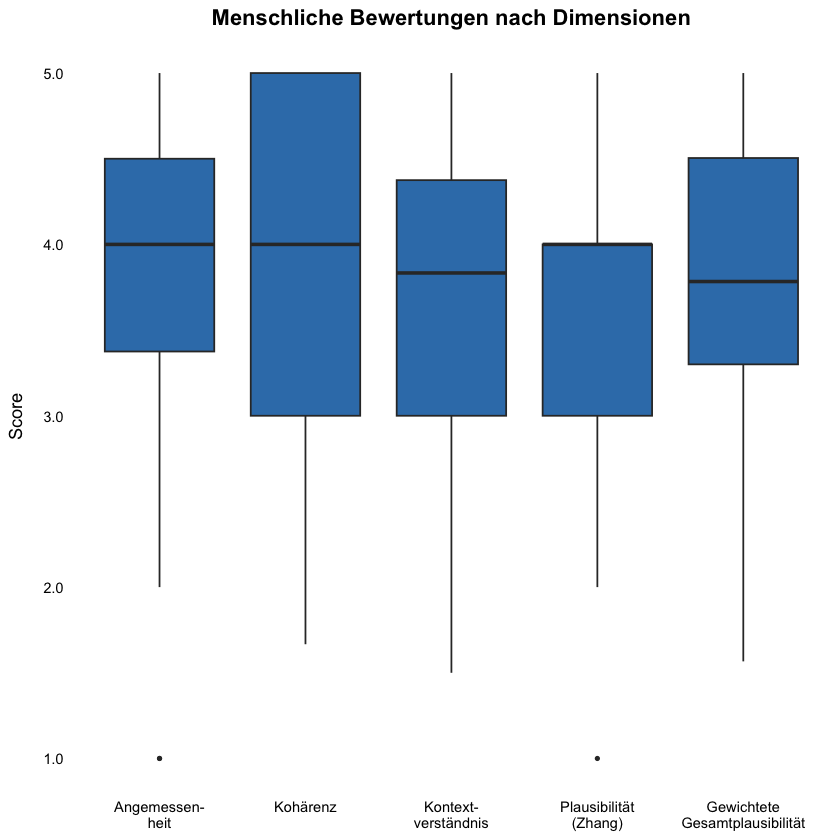

In [84]:
library(ggplot2)
library(scales)
library(tikzDevice)

df_long_agg <- df |>
  select(Frage_Nr, all_of(metriken)) |>
  pivot_longer(
    cols = all_of(metriken),
    names_to = "Dimension",
    values_to = "Score"
  ) |>
  mutate(
    Dimension = factor(
      Dimension,
      levels = metriken,
      labels = c(
        "Angemessenheit",
        "Kohärenz",
        "Kontextverständnis",
        "Plausibilität nach Zhang",
        "Aggregierter Score"
      )
    )
  )


# LaTeX-Pfad für tikzDevice setzen
options(tikzLatex = "/Library/TeX/texbin/pdflatex")


# TikZ-Export für Overleaf
tikz(file = "boxplot_menschlich_dim.tex", 
     width = 6, 
     height = 4,
     standAlone = FALSE)


# Plot erstellen
p <- ggplot(df_long_agg, aes(x = Dimension, y = Score)) +
  geom_boxplot(fill = "#377eb8", outlier.size = 0.8) +
  labs(
    title = "Menschliche Bewertungen nach Dimensionen",
    x = NULL,
    y = "Score"
  ) +
  scale_x_discrete(
    labels = c(
      "Angemessen-\nheit",
      "Kohärenz",
      "Kontext-\nverständnis",
      "Plausibilität\n(Zhang)",
      "Gewichtete\nGesamtplausibilität"
    )
  ) +
  scale_y_continuous(
    n.breaks = 6,
    labels = number_format(accuracy = 0.1)
  ) +
  theme_minimal(base_size = 11) +
  theme(
    plot.title   = element_text(face = "bold", hjust = 0.5),
    axis.text.x  = element_text(angle = 0, vjust = 1, hjust = 0.5),
    axis.title.y = element_text(margin = margin(r = 10)),
    axis.text    = element_text(color = "black"),
    panel.grid   = element_blank()
  )


print(p)  # Plot für TikZ ausgeben


dev.off()  # TikZ-Device schließen


# Dateigröße prüfen
cat("TikZ-Datei erstellt:", file.info("boxplot_menschlich_dim.tex")$size, "Bytes\n")


# Plot im Notebook anzeigen
p


# =====================================================================
# 2. Intra-Rater-Reliabilität – Kendall's W
# =====================================================================

In [85]:
metriken <- c("Angemessenheit_Score", "Kohärenz_Score", "Kontextverständnis_Score",
              "Gesamtplausibilität_Score", "Aggregierter_Score")

kendall_w_values <- sapply(metriken, function(metric) {
  mat <- dcast(df, Frage_Nr ~ Episode, value.var = metric)
  kendall(mat[, -1])$value
})

# Chi-Quadrat und p-Werte
m <- nrow(unique(df["Episode"]))
n <- 8
chi2_values <- m * (n - 1) * kendall_w_values
p_values <- 1 - pchisq(chi2_values, df = n - 1)

# Ergebnistabelle
results <- data.frame(
  Dimension = c("Angemessenheit", "Kohärenz", "Kontextverständnis",
                "Plausibilität nach Zhang", "Aggregierter Score"),
  W = round(kendall_w_values, 4),
  p_formatted = ifelse(p_values < 0.001, "< 0.001",
                       ifelse(p_values < 0.01, "< 0.01",
                              ifelse(p_values < 0.05, "< 0.05", 
                                     round(p_values, 3)))),
  Signifikanz = ifelse(p_values < 0.001, "***",
                       ifelse(p_values < 0.01, "**",
                              ifelse(p_values < 0.05, "*", "n.s.")))
)

kable(results, digits = 3,
      caption = "Intra-Rater-Reliabilität der menschlichen Bewertungen (Kendall's $W$).")



Table: Intra-Rater-Reliabilität der menschlichen Bewertungen (Kendall's $W$).

|                          |Dimension                |     W|p_formatted |Signifikanz |
|:-------------------------|:------------------------|-----:|:-----------|:-----------|
|Angemessenheit_Score      |Angemessenheit           | 0.166|0.114       |n.s.        |
|Kohärenz_Score            |Kohärenz                 | 0.262|< 0.05      |*           |
|Kontextverständnis_Score  |Kontextverständnis       | 0.119|0.306       |n.s.        |
|Gesamtplausibilität_Score |Plausibilität nach Zhang | 0.146|0.178       |n.s.        |
|Aggregierter_Score        |Aggregierter Score       | 0.164|0.118       |n.s.        |

# =====================================================================
# 3. Violin Plot - Verteilung der Scores pro Item und LLM-Antwort
# =====================================================================


Warning message:
“Removed 125 rows containing missing values or values outside the scale range
(`geom_point()`).”
Warning message in (function (texString, cex = 1, face = 1, engine = getOption("tikzDefaultEngine"), :
“Attempting to calculate the width of a Unicode stringusing the pdftex engine. This may fail! See the Unicodesection of ?tikzDevice for more information.”
Warning message in (function (texString, cex = 1, face = 1, engine = getOption("tikzDefaultEngine"), :
“Attempting to calculate the width of a Unicode stringusing the pdftex engine. This may fail! See the Unicodesection of ?tikzDevice for more information.”
Warning message in (function (texString, cex = 1, face = 1, engine = getOption("tikzDefaultEngine"), :
“Attempting to calculate the width of a Unicode stringusing the pdftex engine. This may fail! See the Unicodesection of ?tikzDevice for more information.”
Warning message in (function (texString, cex = 1, face = 1, engine = getOption("tikzDefaultEngine"), :
“Attempti

pdf 
  2

TikZ-Datei erstellt: 195134 Bytes


Warning message:
“Removed 94 rows containing missing values or values outside the scale range
(`geom_point()`).”


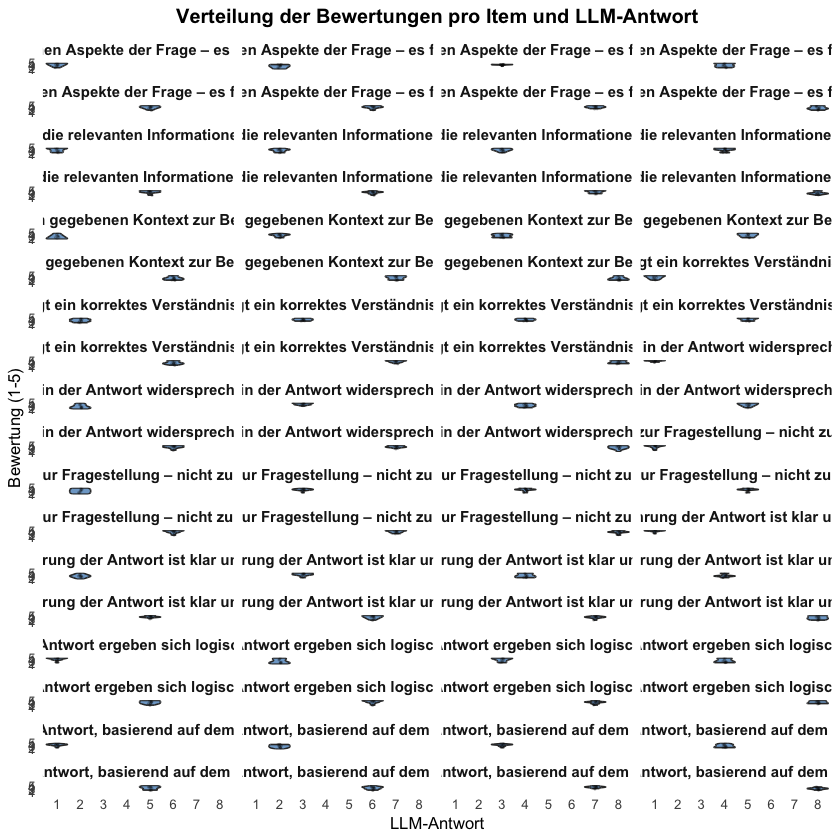

In [86]:
# Daten vorbereiten: 8 Items (ohne Plausibilität)
# Behalte die Spaltennamen, um für jedes Item separat darzustellen
df_violin <- df_long |>
  filter(!is.na(Score)) |>
  filter(!grepl("Plausibilität", Spalte)) |>
  select(Frage_Nr, Spalte, Score) |>
  mutate(
    # Kürzere Labels für die Items erstellen
    Item_Label = case_when(
      Spalte == "Kontextverständnis_1" ~ "Kontext 1",
      Spalte == "Kontextverständnis_2" ~ "Kontext 2",
      Spalte == "Kontextverständnis_3" ~ "Kontext 3",
      Spalte == "Kohärenz_1" ~ "Kohärenz 1",
      Spalte == "Kohärenz_2" ~ "Kohärenz 2",
      Spalte == "Kohärenz_3" ~ "Kohärenz 3",
      Spalte == "Angemessenheit_1" ~ "Angemess. 1",
      Spalte == "Angemessenheit_2" ~ "Angemess. 2",
      TRUE ~ Spalte
    )
  )


# TikZ-Export für Overleaf
tikz(file = "violinplot_menschlich_items.tex", 
     width = 10, 
     height = 6,
     standAlone = FALSE)


# Violin Plot mit Facetten für jedes Item erstellen
p_violin <- ggplot(df_violin, aes(x = factor(Frage_Nr), y = Score)) +
  geom_violin(fill = "#377eb8", alpha = 0.7) +
  geom_jitter(width = 0.1, alpha = 0.2, size = 0.3) +
  facet_wrap(~Item_Label, ncol = 4) +
  labs(
    title = "Verteilung der Bewertungen pro Item und LLM-Antwort",
    x = "LLM-Antwort",
    y = "Bewertung (1-5)"
  ) +
  scale_y_continuous(
    breaks = 1:5,
    limits = c(1, 5)
  ) +
  theme_minimal(base_size = 10) +
  theme(
    plot.title   = element_text(face = "bold", hjust = 0.5),
    axis.text.x  = element_text(angle = 0, vjust = 1, hjust = 0.5, size = 8),
    axis.title   = element_text(size = 10),
    axis.text.y  = element_text(size = 8),
    strip.text   = element_text(size = 9, face = "bold"),
    panel.grid   = element_blank()
  )


print(p_violin)  # Plot für TikZ ausgeben


dev.off()  # TikZ-Device schließen


# Dateigröße prüfen
cat("TikZ-Datei erstellt:", file.info("violinplot_menschlich_fragen.tex")$size, "Bytes\n")


# Plot im Notebook anzeigen
p_violin
